In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from glob import glob
import math

# Import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
import plotly.express as px

import keras

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

import os # used for navigating to image path
import imageio # used for writing images

import datetime

from PIL import Image
from PIL import ImageFile

##not sure why I need this but I do
ImageFile.LOAD_TRUNCATED_IMAGES = True


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


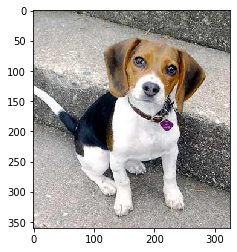

In [2]:
## Load the image
data = plt.imread('/Users/ilya/Desktop/U-Capstone/Images/n02088364-beagle/n02088364_2019.jpg')

# Display the image
plt.imshow(data)
plt.show()

In [86]:
# load the model
vgg16_model = VGG16()

def VGG16_predict(img_path):
    # load an image from file
    image = load_img(img_path, target_size=(224, 224))

    # convert the image pixels to a numpy array
    image = img_to_array(image)
    
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # prepare the image for the VGG model
    image = preprocess_input(image)

    # predict the probability across all output classes
    yhat = vgg16_model.predict(image)

    # convert the probabilities to class labels
    label = decode_predictions(yhat)
    
    return label

In [3]:
file_paths = []
image_ids = []
breed_labels = []

for directory in os.listdir('/Users/ilya/Desktop/U-Capstone/Images/'):
    if directory != '.DS_Store':
        for file in os.listdir('/Users/ilya/Desktop/U-Capstone/Images/'+str(directory)):
            file_paths.append('/Users/ilya/Desktop/U-Capstone/Images/'
                              +str(directory)+'/'+str(file))
            breed_labels.append(str(directory).split('-')[1])
            image_ids.append(file)

df = pd.DataFrame()

df['file_path'] = file_paths
df['image_id'] = image_ids
df['breed_label'] = breed_labels

In [4]:
#figuring out heights and widths of each image for better processing

list_of_heights = []
list_of_widths = []

for path in df['file_path']:
    image = load_img(path)
    np_array = img_to_array(image)
    list_of_heights.append(np_array.shape[0])
    list_of_widths.append(np_array.shape[1])

df.loc[:,('img_height')] = list_of_heights
df.loc[:,('img_width')] = list_of_widths

In [5]:
img_size = df[['img_height','img_width']]

img_size.describe()

img_height     img_width
count  20580.000000  20580.000000
mean     385.861224    442.531876
std      124.863446    142.792308
min      100.000000     97.000000
25%      333.000000    361.000000
50%      375.000000    500.000000
75%      453.000000    500.000000
max     2562.000000   3264.000000

In [6]:
#binning a dataframe above by size for better visualization

img_size.loc[:,('img_height_bin')] = pd.cut(img_size['img_height'], list(range(0,4004, 100)))

img_size.loc[:,('img_width_bin')] = pd.cut(img_size['img_width'], list(range(0,4004, 100)))

img_size = img_size[img_size['img_height'] <= 2000]

img_size = img_size[img_size['img_width'] <= 2000]

heights = img_size.groupby('img_height_bin').count()[['img_height']].reset_index()
widths = img_size.groupby('img_width_bin').count()[['img_width']].reset_index()

heights.loc[:,('img_height_bin')] = heights['img_height_bin'].astype('str')
heigths2 = heights.rename(columns = {'img_height':'height_img_count'})

widths.loc[:,('img_width_bin')] = widths['img_width_bin'].astype('str')
widths2 = widths.rename(columns = {'img_width':'width_img_count'})

sizes_df = heigths2.merge(widths2, left_index = True, right_index = True).rename(columns = {'img_height_bin':'size'})\
           [['size','height_img_count','width_img_count']]

sizes_df.head(4)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



size  height_img_count  width_img_count
0    (0, 100]                 3                2
1  (100, 200]               901              808
2  (200, 300]              2233             1847
3  (300, 400]             11395             4779

In [7]:
fig = px.bar(sizes_df.head(20), x='size', y=['height_img_count','width_img_count'], barmode='group')

fig.update_layout(title_text = 'Image Size – Height and Width Histogram',
                  yaxis_title = 'Number of Images',
                  xaxis_title = 'Size')

fig.update_layout(height = 500, width = 1000)

fig.show()

ValueError: All arguments should have the same length. The length of argument `y` is 2, whereas the length of previous arguments ['size'] is 20

In [8]:
#we count the number of dog images per breed discovering the fact the the dataset in slightly imbalanced

breed_count_df = df.groupby('breed_label').count().reset_index()\
                .rename(columns = {'file_path':'dog_count'})[['breed_label','dog_count']]\
                .sort_values(by = 'dog_count', ascending = False)

fig = px.bar(breed_count_df, x='breed_label', y='dog_count')

fig.update_layout(title_text = 'Image Count by Breed',
                  yaxis_title = 'Number of Images',
                  xaxis_title = 'Dog Breed')

fig.show()

In [49]:
df2 = df.merge(breed_count_df, left_on= 'breed_label', right_on = 'breed_label')
final_df = df2[df2.dog_count > 200]
final_df = final_df.sample(frac = 1)
final_df = final_df[['file_path','image_id','breed_label']]

In [51]:
train_df = final_df.iloc[:round(len(final_df)*0.8)]
test_df = final_df.iloc[round(len(final_df)*0.8):]

In [11]:
def img_to_np_array(path):
    image = Image.open(path)
    image = image.resize((250,250))
    image = image.convert('L')
    image = np.array(image)
    return image

In [52]:
train_data = []

time1 = datetime.datetime.now()

for file_path, breed_label in zip(train_df['file_path'], train_df['breed_label']):
    img_np_array = img_to_np_array(file_path)
    train_data.append([img_np_array, breed_label])

np.random.shuffle(train_data)    

train_images = np.array([i[0] for i in train_data])
train_labels = np.array([i[1] for i in train_data])

train_images = train_images.reshape(-1, 250, 250, 1)
train_labels = pd.get_dummies(train_labels).to_numpy()
    
time2 = datetime.datetime.now()
elapsedTime = time2 - time1
run_time = elapsedTime.total_seconds()

print('Run time: {} seconds'.format(run_time))

Run time: 14.917471 seconds


In [53]:
test_data = []

time1 = datetime.datetime.now()

for file_path, breed_label in zip(test_df['file_path'], test_df['breed_label']):
    img_np_array = img_to_np_array(file_path)
    test_data.append([img_np_array, breed_label])

np.random.shuffle(test_data)    

test_images = np.array([i[0] for i in test_data])
test_labels = np.array([i[1] for i in test_data])

test_images = test_images.reshape(-1, 250, 250, 1)
test_labels = pd.get_dummies(test_labels).to_numpy()
    
time2 = datetime.datetime.now()
elapsedTime = time2 - time1
run_time = elapsedTime.total_seconds()

print('Run time: {} seconds'.format(run_time))

Run time: 5.502386 seconds


In [58]:
print("Shape of train image dataset: {}".format(train_images.shape))
print("Shape of test image dataset: {}".format(test_images.shape))
print("Shape of train label dataset: {}".format(train_labels.shape))
print("Shape of test label dataset: {}".format(test_labels.shape))

Shape of train image dataset: (2603, 250, 250, 1)
Shape of test image dataset: (651, 250, 250, 1)
Shape of train label dataset: (2603, 15)
Shape of test label dataset: (651, 15)


In [59]:
# Import the necessary components from Keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D

# Initialize the model object
model = Sequential()

# Add a convolutional layer
model.add(Conv2D(filters = 16, kernel_size=3, strides = 1,
                 padding = 'same', activation='relu',
                 input_shape=(250, 250, 1)))

model.add(MaxPooling2D(pool_size = 2))

# Add a convolutional layer
model.add(Conv2D(filters = 32, kernel_size=3, strides = 1,
                 padding = 'same', activation='relu'))

model.add(MaxPooling2D(pool_size = 2))

model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(15))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 250, 250, 16)      160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)               

In [60]:
model.fit(train_images, train_labels, batch_size = 50, epochs = 3, validation_split=0.3)

Epoch 1/3
37/37 [==============================] - 78s 2s/step - loss: 7.0147 - accuracy: 0.0611 - val_loss: 7.8203 - val_accuracy: 0.0602
Epoch 2/3
37/37 [==============================] - 58s 2s/step - loss: 7.5934 - accuracy: 0.0725 - val_loss: 9.2087 - val_accuracy: 0.0679
Epoch 3/3
37/37 [==============================] - 62s 2s/step - loss: 8.8036 - accuracy: 0.0813 - val_loss: 6.9137 - val_accuracy: 0.0679


In [61]:
model.evaluate(test_images, test_labels)

21/21 [==============================] - 5s 209ms/step - loss: 6.6106 - accuracy: 0.0814


[6.610647678375244, 0.08141320943832397]

In [76]:
dumpling = img_to_np_array('/Users/ilya/Desktop/U-Capstone/dumpling2.jpg').reshape(1,250,250,1)

In [85]:
model.predict(img_to_np_array('/Users/ilya/Desktop/U-Capstone/dumpling2.jpg').reshape(1,250,250,1))

array([[  51.90093 , -104.7352  ,   31.10199 ,   58.576202, -100.89682 ,
          23.497257,   74.00261 ,  -76.86763 ,  -78.579414,   63.131   ,
          82.89842 ,  -78.467186,   45.931473,   69.42051 ,  -46.035618]],
      dtype=float32)